# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

In [1]:
# Import necessary libraries
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import passengers.csv and set it as a time-series object. Plot the TS
df = pd.read_csv('passengers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


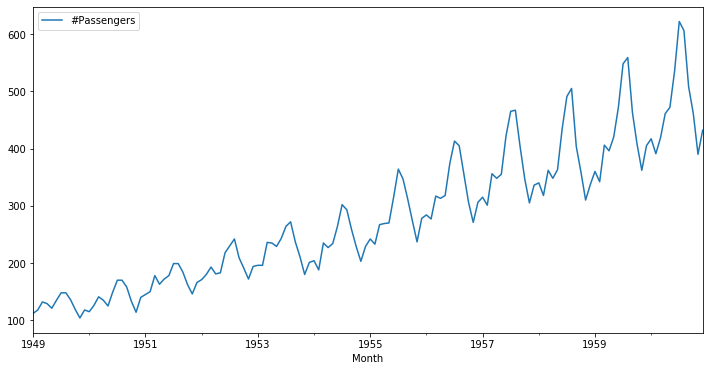

In [2]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

#plot
df.plot(figsize=(12,6))

## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [29]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
def stationarity_check(df):
    
    # Get rolling stats
    rolmean = df.rolling(window=8, center=False).mean()
    rolstd = df.rolling(window=8, center=False).std()
    
    # perform dfuller test, output print below plots
    from statsmodels.tsa.stattools import adfuller
    
    dftest = adfuller(df['#Passengers'])
    
    #plot original and rolling stats in one plot
    fig = plt.figure(figsize=(12,7))
    lw=2
    orig = plt.plot(df, color="blue", lw=lw, label="Original")
    mean = plt.plot(rolmean, color="red", lw=lw, label="Rolling Mean")
    std = plt.plot(rolstd, color="black", lw=lw, label="Rolling STD")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    
    # produce and print output from Dfuller test
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                            '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print("Results of DFuller test")
    print(dfoutput)
    
    return None

Use your newly created function on the airpassenger data set.

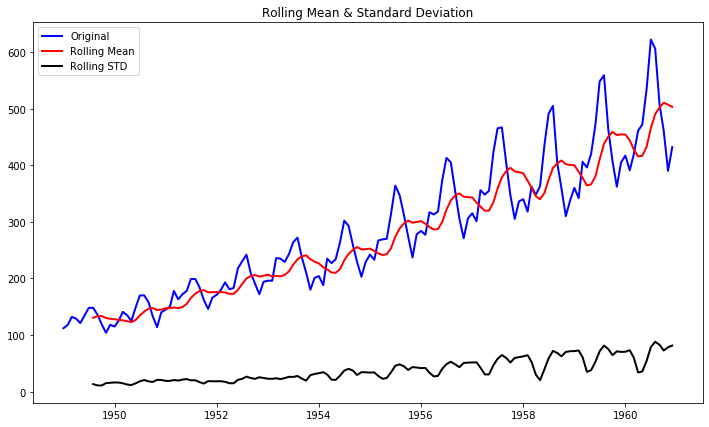

Results of DFuller test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [30]:
# Code here
stationarity_check(df)

## Perform a log() and sqrt() transform

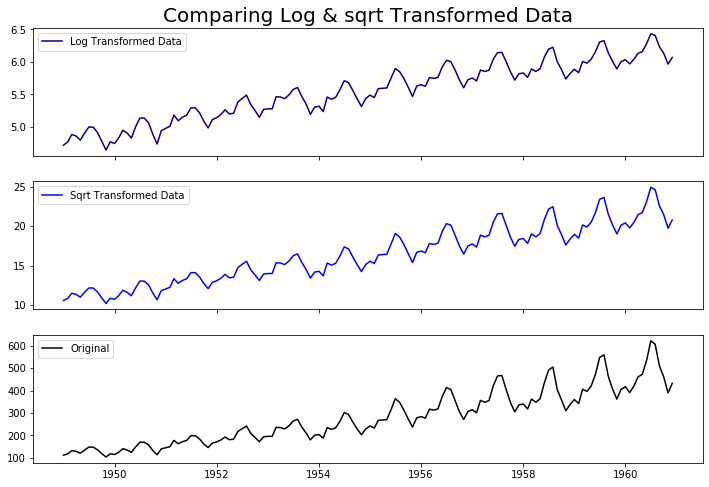

In [18]:
# Log transform timeseries and compare with original to check the effect
log_df = np.log(df)
sqrt_df = np.sqrt(df)

#plot
fig, ax = plt.subplots(nrows=3, sharex='col', sharey='row', figsize=(12,8))

ax[0].plot(log_df, color="navy", label="Log Transformed Data")
ax[0].legend()
ax[0].set_title("Comparing Log & sqrt Transformed Data", fontsize=20)
ax[1].plot(sqrt_df, color="blue", label="Sqrt Transformed Data")
ax[1].legend()
ax[2].plot(df, color="black", label="Original")
ax[2].legend()
plt.show()


moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

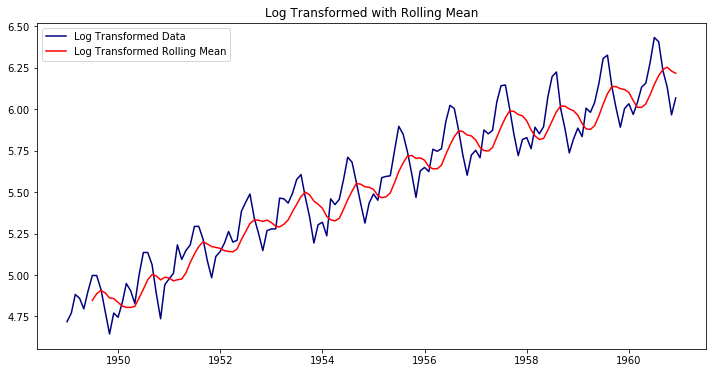

In [22]:
# your code here
rolmean_lg = log_df.rolling(window=7, center=False).mean()
fig = plt.figure(figsize=(12,6))
plt.plot(log_df, color="navy", label="Log Transformed Data")
plt.plot(rolmean_lg, color="red", label="Log Transformed Rolling Mean")
plt.title("Log Transformed with Rolling Mean")
plt.legend(loc="best")
plt.show(block=False)

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [24]:
# Subtract the moving average from the original data and check head for Nans
df_minus_rolmean_lg = log_df - rolmean_lg
df_minus_rolmean_lg.head(10)


,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,0.150059
1949-08-01,0.110242
1949-09-01,0.005404


In [25]:
# Drop the NaN values from timeseries calculated above
df_minus_rolmean_lg.dropna(inplace=True)

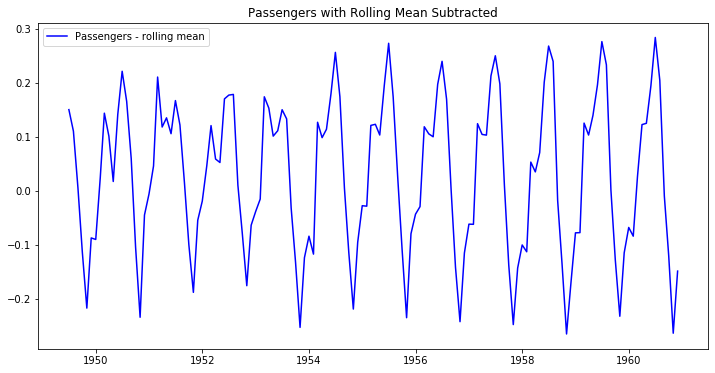

In [26]:
# Plot the result
fig = plt.figure(figsize=(12,6))
plt.plot(df_minus_rolmean_lg, color="blue", label="Passengers - rolling mean")
plt.legend(loc="best")
plt.title("Passengers with Rolling Mean Subtracted")
plt.show(block=False)

Finally, use your function `check_stationarity` to see if this series is considered stationary!

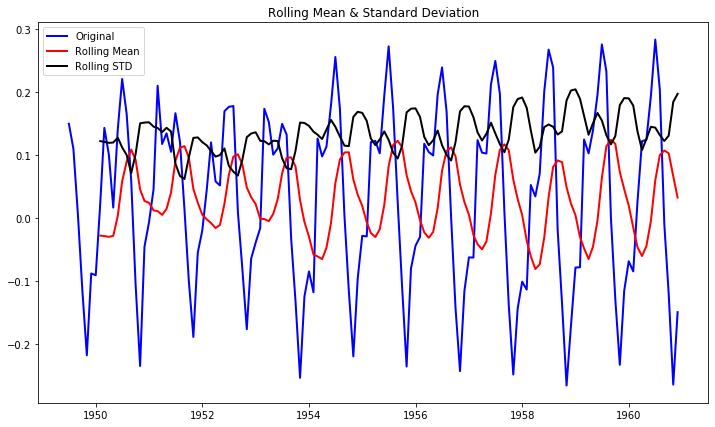

Results of DFuller test
Test Statistic                  -2.348027
p-value                          0.156946
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [31]:
# Your code here
stationarity_check(df_minus_rolmean_lg)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


In [32]:
# Your conclusion here
# We fail to reject the null hypothesis because our p-value is higher 
# than the critical values, so we must conclude that the ts is not stationary.

## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

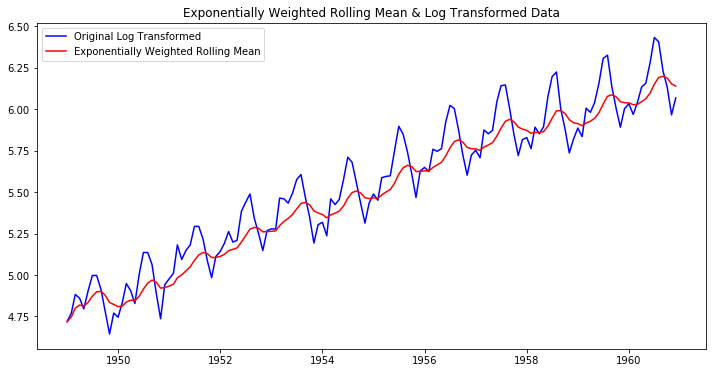

In [36]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_rolmean = log_df.ewm(halflife = 4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,6))
log_orig = plt.plot(log_df, color="blue", label="Original Log Transformed")
rolmean_exp = plt.plot(exp_rolmean, color="red", label="Exponentially Weighted Rolling Mean")
plt.legend(loc="best")
plt.title("Exponentially Weighted Rolling Mean & Log Transformed Data")
plt.show(block=False)

In [38]:
# Subtract the moving average from the original data and plot
log_df_minus_exprolmean = np.log(df) - exp_rolmean
log_df_minus_exprolmean.isnull().sum()

#Passengers    0
dtype: int64

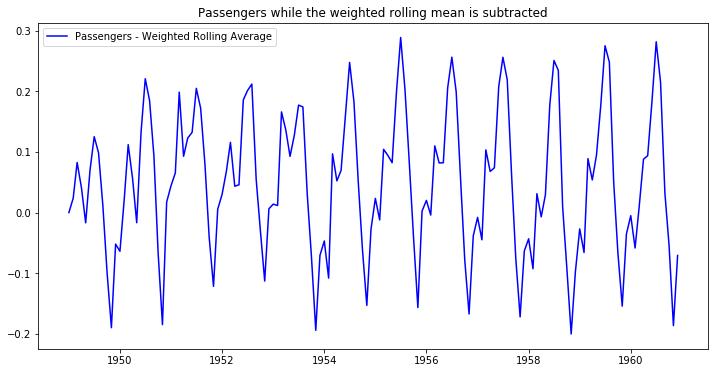

In [41]:
fig = plt.figure(figsize=(12,6))
plt.plot(log_df_minus_exprolmean, color="blue", label="Passengers - Weighted Rolling Average")
plt.legend(loc="best")
plt.title("Passengers while the weighted rolling mean is subtracted")
plt.show(block=False)

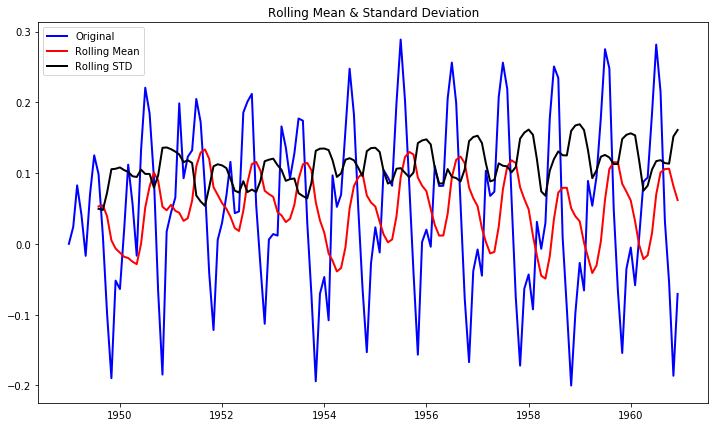

Results of DFuller test
Test Statistic                  -3.297250
p-value                          0.015002
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [42]:
# do a stationarity check
stationarity_check(log_df_minus_exprolmean)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


In [43]:
# Your conclusion here
# the p-value is below 0.05 so we can reject the null hypothesis and
# conclude that the data is not stationary, even though there
# appears to be strong seasonality still present

## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [44]:
# difference your data and look at the head
log_df_minus_exprolmean_diff = log_df_minus_exprolmean.diff(periods=12)
log_df_minus_exprolmean_diff.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


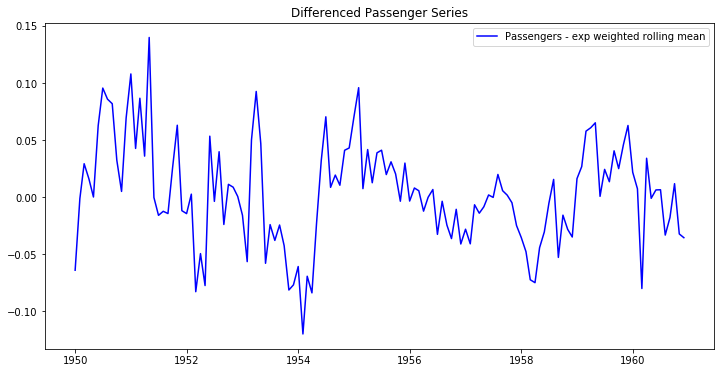

In [45]:
# plot your differenced time series
fig = plt.figure(figsize=(12,6))
plt.plot(log_df_minus_exprolmean_diff, color="blue", label="Passengers - exp weighted rolling mean")
plt.legend(loc="best")
plt.title("Differenced Passenger Series")
plt.show(block=False)

In [46]:
# drop nas
log_df_minus_exprolmean_diff.dropna(inplace=True)

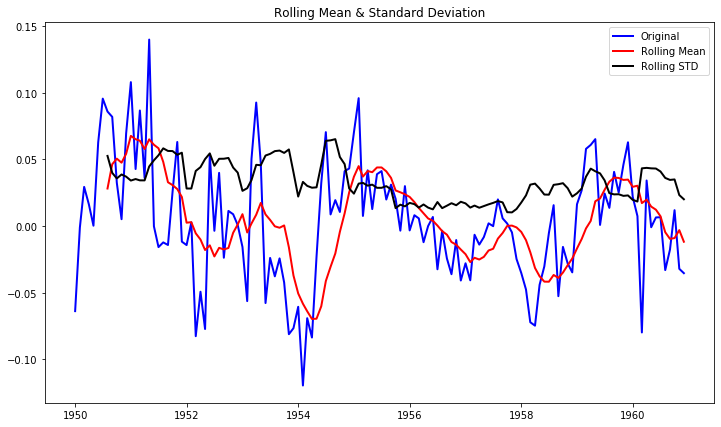

Results of DFuller test
Test Statistic                  -3.601666
p-value                          0.005729
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [47]:
# perform the stationarity check
stationarity_check(log_df_minus_exprolmean_diff)

### Your conclusion

In [48]:
# Your conclusion here
# Our p-value is sufficiently low enough for us to reject the null
# even though there are fluctuations they appear to be totally random, 
# meaning we have effectively controlled for them.

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.